In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import os
import pickle

# Ensure src folder is importable
import sys
PROJECT_ROOT = os.path.abspath("..")  # notebook is in 'notebooks/'
sys.path.append(PROJECT_ROOT)

# Import CF engines
from src.cf_engines import predict_ratings_item_cf

# Paths
PROCESSED_DIR = "../data/processed"
ratings_file = os.path.join(PROCESSED_DIR, "ratings_processed.csv")
movies_file = os.path.join(PROCESSED_DIR, "movies_processed.csv")
sparse_file = os.path.join(PROCESSED_DIR, "user_item_matrix.pkl")


In [2]:
# Load preprocessed data
ratings = pd.read_csv(ratings_file)
movies = pd.read_csv(movies_file)

# Load sparse user-item matrix
with open(sparse_file, "rb") as f:
    user_item_matrix = pickle.load(f)

print("Sparse matrix shape:", user_item_matrix.shape)
ratings.head()
movies.head()


Sparse matrix shape: (943, 1682)


,movieId,movie_idx,title,release_date,imdb_url
0,1,24,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,147,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,233,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,47,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,75,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995)


In [3]:
# Compute item-item similarity using cosine similarity
item_sim_matrix = cosine_similarity(user_item_matrix.T)

print("Item similarity matrix shape:", item_sim_matrix.shape)


Item similarity matrix shape: (1682, 1682)


In [4]:
# Example: Recommend top 10 movies for user_idx 5
user_idx = 5
recommendations = predict_ratings_item_cf(
    user_idx=user_idx,
    user_item_matrix=user_item_matrix,
    item_sim_matrix=item_sim_matrix,
    movies_df=movies,
    top_n=10,
    k=5
)

recommendations


,movie_idx,title
477,186,"Philadelphia Story, The (1940)"
479,78,North by Northwest (1959)
480,920,"Apartment, The (1960)"
499,948,Fly Away Home (1996)
600,1168,For Whom the Bell Tolls (1943)
605,884,All About Eve (1950)
953,1001,Unzipped (1995)
1062,593,"Little Princess, A (1995)"
1385,1170,Tetsuo II: Body Hammer (1992)
1454,1351,"Outlaw, The (1943)"


In [5]:
for user in [0, 10, 25]:
    print(f"Top 5 recommendations for user {user}:")
    display(predict_ratings_item_cf(
        user_idx=user,
        user_item_matrix=user_item_matrix,
        item_sim_matrix=item_sim_matrix,
        movies_df=movies,
        top_n=5,
        k=5
    ))
    print("\n")


Top 5 recommendations for user 0:


,movie_idx,title
520,888,"Deer Hunter, The (1978)"
1099,463,What Happened Was... (1994)
1125,1115,"Old Man and the Sea, The (1958)"
1203,1460,To Be or Not to Be (1942)
1455,1344,Beat the Devil (1954)




Top 5 recommendations for user 10:


,movie_idx,title
38,462,Strange Days (1995)
153,88,Monty Python's Life of Brian (1979)
427,649,Harold and Maude (1971)
530,333,Shine (1996)
1038,418,Hamlet (1996)




Top 5 recommendations for user 25:


,movie_idx,title
72,556,Maverick (1994)
142,56,"Sound of Music, The (1965)"
236,77,Jerry Maguire (1996)
659,465,Fried Green Tomatoes (1991)
738,435,Pretty Woman (1990)


In [6]:
# Example: Save top 10 recommendations for all users
top_n = 10
all_recs = []

for user_idx in range(user_item_matrix.shape[0]):
    recs = predict_ratings_item_cf(
        user_idx=user_idx,
        user_item_matrix=user_item_matrix,
        item_sim_matrix=item_sim_matrix,
        movies_df=movies,
        top_n=top_n,
        k=5
    )
    recs["user_idx"] = user_idx
    all_recs.append(recs)

all_recs_df = pd.concat(all_recs, ignore_index=True)
all_recs_df.to_csv(os.path.join(PROCESSED_DIR, "item_cf_top10.csv"), index=False)
print("Item CF recommendations saved!")


Item CF recommendations saved!


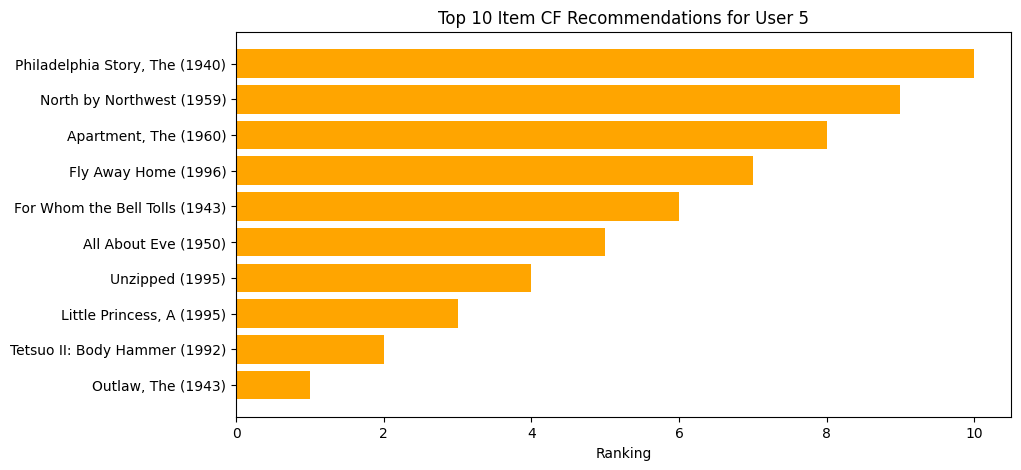

In [7]:
import matplotlib.pyplot as plt

user_idx = 5
user_recs = all_recs_df[all_recs_df["user_idx"] == user_idx]

plt.figure(figsize=(10,5))
plt.barh(user_recs["title"], range(len(user_recs), 0, -1), color="orange")
plt.xlabel("Ranking")
plt.title(f"Top {len(user_recs)} Item CF Recommendations for User {user_idx}")
plt.gca().invert_yaxis()  # Highest rank at top
plt.show()


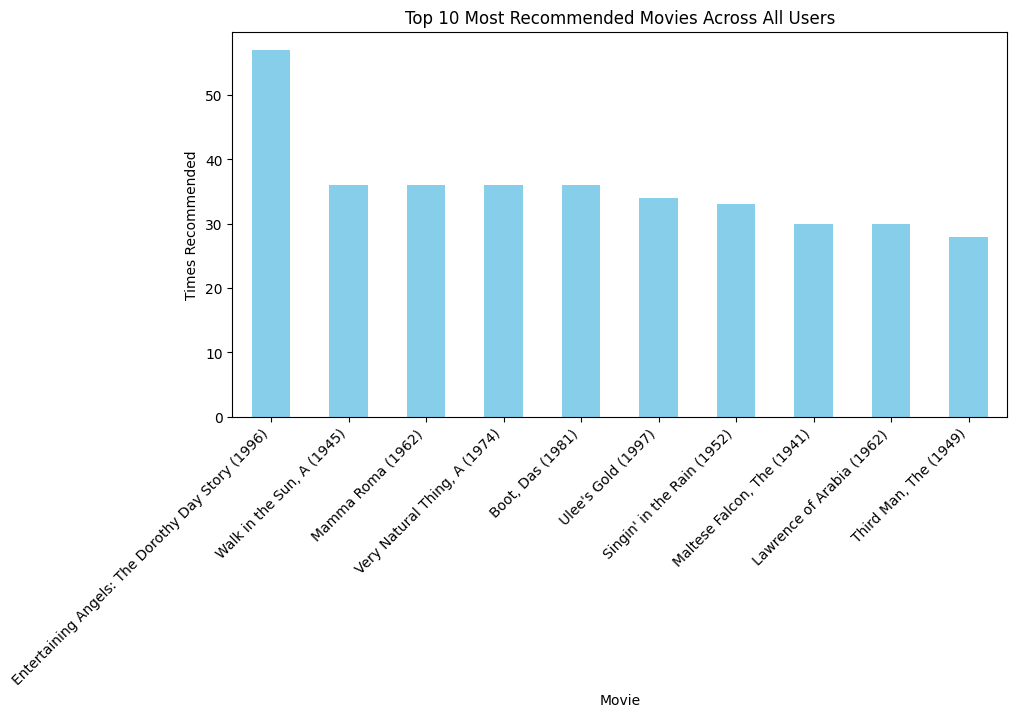

In [8]:
top_movies = all_recs_df["title"].value_counts().head(10)

plt.figure(figsize=(10,5))
top_movies.plot(kind="bar", color="skyblue")
plt.xlabel("Movie")
plt.ylabel("Times Recommended")
plt.title("Top 10 Most Recommended Movies Across All Users")
plt.xticks(rotation=45, ha="right")
plt.show()
